In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

# Problema de Descomposición de Benders

Una empresa requiere comprar materiales (x), para producir un unico producto. La demanda del producto es incierta y se modela mediante diferentes escenarios. La empresa debe decidir cuánto producir antes de conocer la demanda exacta y cuánto comprar adicionalmente después de conocer la demanda real, que depende del escenario que se materialice.

Parámetros y variables
* x: Cantidad de material a comprar
* y_s: Cantidad de material adicional a comprar en el escenario s.
* t_s: Unidades de material necesarias para producir una unidad internamente en el escenario s.
* w_s: Unidades de material necesarias para producir una unidad externamente en el escenario s.
* h_s: Demanda mínima a satisfacer en el escenario s.
* p_s: Probabilidad de ocurrencia del escenario s.


Modelo

$
\min_x ~x + \sum_s p_s \cdot 2y_s
$

$
s.a. ~~ t_s \cdot x + w_s \cdot y_s \geq h_s, \quad \forall s \in S
$

$
~~ ~~~ ~~ ~~ 0 \leq x \leq 3
$

$
~~ ~~~ ~~ ~~ y \geq 0
$

Definición de parametros:

In [2]:
k = 2
S = range(k)
h = [3,2]
t = [2,1]
w = [1,2]
p = [1/4,3/4]

L = 0
xlb = 0
xub = 3

# Espacio lineal para graficar
x_vals = np.linspace(xlb -1, xub + 1, 100)

Funcion auxiliar para graficar los cortes y la región factible

In [3]:
def graficar_region_factible(x_vals, cortes, iter, sol, L=0):

    # Tamaño de la figura
    plt.figure(figsize=(10, 6))
    ax = plt.gca()  # Get current axes
    ax.set_facecolor('black')

    # Draw x and y axis lines
    plt.axhline(0, color='white', lw=1)  # Add y-axis through the origin
    plt.axvline(0, color='white', lw=1)  # Add x-axis through the origin
    
    # Hacer un llenado inical
    plt.plot(x_vals, [L for _ in x_vals], color='red', linestyle='--',label=f'Cota inferior')
    plt.fill_between([0, 3], 0, 10, color='grey', alpha=0.4, label='Region Factible')
    
    # Para cada corte, llenar el area infactible
    for corte in cortes:

        coeffs = corte[0]

        if corte[-1] == 'opt':
            y_vals = [coeffs[1] * x_val + coeffs[0] for x_val in x_vals]
            plt.plot(x_vals, y_vals, label=f'Corte de opt {cortes.index(corte)+1}')
            plt.fill_between(x_vals, -10, y_vals, color='black', alpha=0.5)
        else:
            const = -coeffs[0] / coeffs[1]
            plt.axvline(x=const, color='blue', linestyle='--', label=f'Corte de fact {cortes.index(corte)+1}')
            plt.fill_betweenx(np.linspace(-10, 10, 100), 0, const, color='black', alpha=0.5)

    # Plot candidate point
    plt.scatter(sol[0], sol[1], color='red', zorder=5, label='Solucion candidata')
    
    plt.xlim(x_vals[0], x_vals[-1])
    plt.ylim(-1, 10)
    plt.xlabel('x')
    plt.ylabel('theta')
    plt.title(f'Iteration {iter}')
    plt.legend()
    plt.show()

Clase de Python para el problema maestro (unidimensional)

In [4]:
class Maestro:

    def __init__(self, xlb=0, xub=GRB.INFINITY, L=0):
        
        # Definir el modelo
        self.model = gp.Model('Maestro')
        self.model.Params.OutputFlag = 0

        # Variables
        self.x = self.model.addVar(name='x')
        self.theta = self.model.addVar(name='theta')

        self.model.addConstr(self.x <= xub)
        self.model.addConstr(self.theta >= L)

        # Funcion objetivo
        self.model.setObjective(self.x + self.theta)

        # Actualizar el modelo
        self.model.update()

        self.iter = 0

    def optimizar(self):

        self.model.update()
        self.model.optimize()
        self.iter +=1 
        
        print(f"{'#'*8} Iteracion {self.iter} {'#'*8}")
        print("Objetivo maestro:", self.model.objVal) 
        print("Solucion candidata: x =", self.x.X)
        
    def agregar_corte_factibilidad(self, coeffs):

        # agregar corte
        self.model.addConstr(coeffs[0] + coeffs[1] * self.x <= 0)
        print(f"Corte de factibilidad: {coeffs[0]} + {coeffs[1]}x <= 0")

    def agregar_corte_optimalidad(self, coeffs):

        # agregar corte
        self.model.addConstr(coeffs[0] + coeffs[1] * self.x <= self.theta)
        print(f"Corte de optimalidad: {coeffs[0]} + {coeffs[1]}x <= theta")
        

Definir el problema maestro

In [5]:
maestro = Maestro(xub=xub, L=L)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-29


Inicialización de los subproblemas

In [6]:
sub = []
y = []
dem = []
cota = []

for s in S:
    sub.append(gp.Model())
    sub[s].Params.OutputFlag = 0
    sub[s].Params.InfUnbdInfo = 1
    y.append(sub[s].addVar())
    dem.append(sub[s].addConstr(w[s]*y[s] >= 0))
    cota.append(sub[s].addConstr(y[s] <= 2))
    sub[s].setObjective(2*y[s])

Loop principal

######## Iteracion 1 ########
Objetivo maestro: 0.0
Solucion candidata: x = 0.0
Escenario 0 : infactible, -rayo dual = [-1.  1.]
Corte de factibilidad: 1.0 + -2.0x <= 0


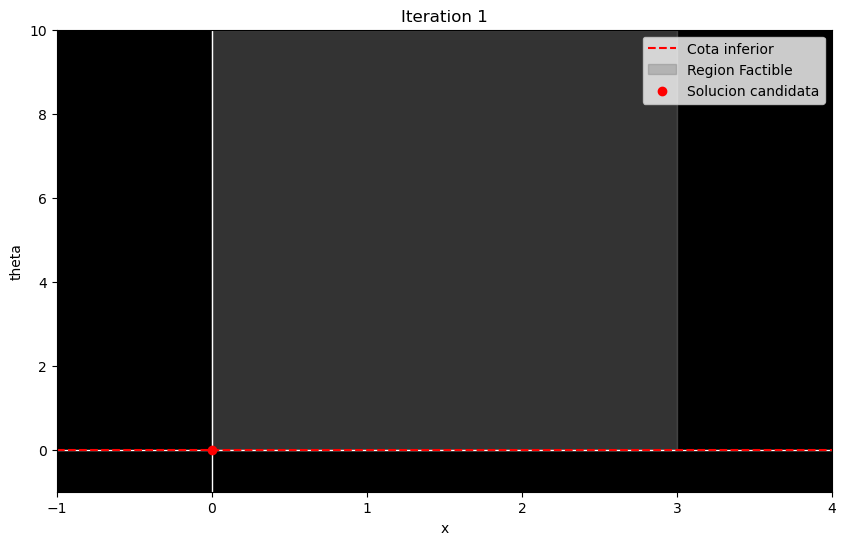

######## Iteracion 2 ########
Objetivo maestro: 0.5
Solucion candidata: x = 0.5
Escenario 0 : objetivo = 4.0 , v'ertice dual = [2. 0.]
Escenario 1 : objetivo = 1.5 , v'ertice dual = [1. 0.]
Theta: 0.0 E[Q(x)]: 2.125

Corte de factibilidad: 3.0 + -1.75x <= 0


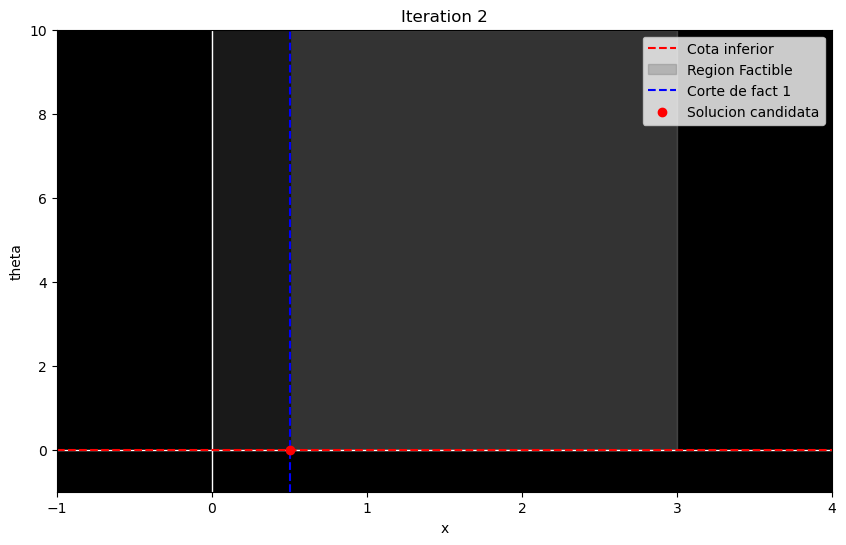

######## Iteracion 3 ########
Objetivo maestro: 1.7142857142857142
Solucion candidata: x = 1.7142857142857142
Escenario 0 : objetivo = 0.0 , v'ertice dual = [0. 0.]
Escenario 1 : objetivo = 0.2857142857142858 , v'ertice dual = [1. 0.]
Theta: 0.0 E[Q(x)]: 0.21428571428571436

Corte de factibilidad: 1.5 + -0.75x <= 0


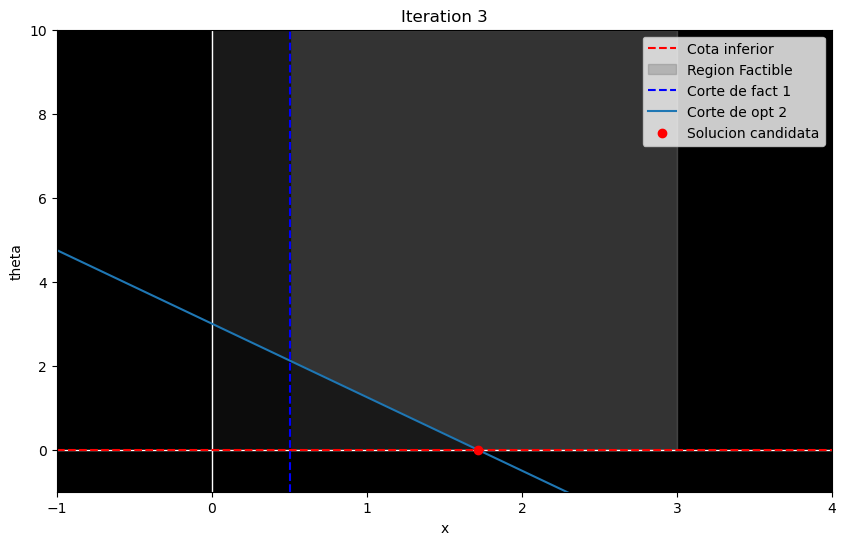

######## Iteracion 4 ########
Objetivo maestro: 2.0
Solucion candidata: x = 2.0
Escenario 0 : objetivo = 0.0 , v'ertice dual = [0. 0.]
Escenario 1 : objetivo = 0.0 , v'ertice dual = [1. 0.]
Theta: 0.0 E[Q(x)]: 0.0



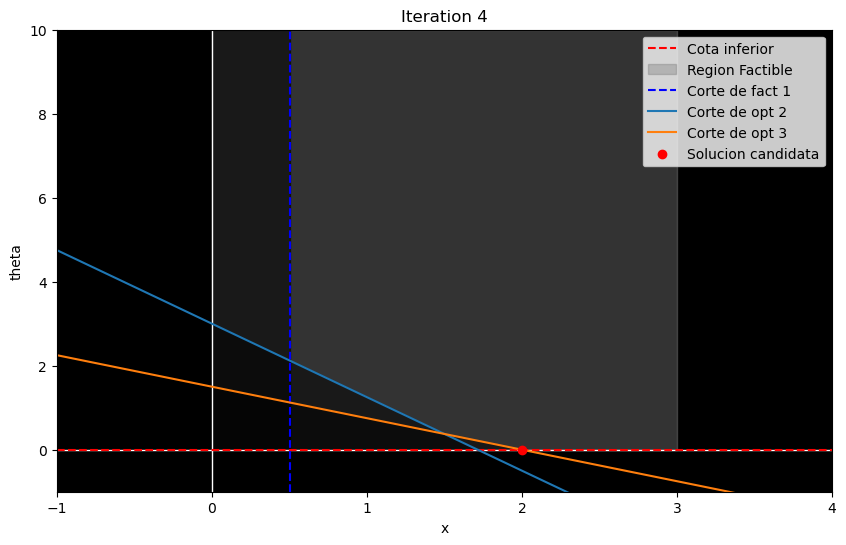

In [7]:
cortes = []
while True:

    maestro.optimizar() 

    pi = np.zeros((k,2))
    obj2 = 0
    infact = -1
    
    # actualizamos el lado derecho de las restricciones y optimizamos
    for s in S:
        dem[s].RHS = h[s] - t[s]*maestro.x.X
        sub[s].optimize()
                
        if sub[s].Status == GRB.OPTIMAL:
            obj2 += p[s]*sub[s].objVal
            pi[s][0] = dem[s].Pi
            pi[s][1] = cota[s].Pi
            print("Escenario",s,": objetivo =",sub[s].objVal,", v\'ertice dual =",pi[s])
        elif sub[s].Status == GRB.INFEASIBLE:
            pi[s] = sub[s].farkasDual
            print("Escenario",s,": infactible, -rayo dual =",pi[s])
            infact = s
            break
        else:
            print("Error")

       
    if infact >= 0:
        # calculamos los coeficientes
        coeffs = (-pi[infact][1]*2 - pi[infact][0]*h[infact], pi[infact][0]*t[s])
        maestro.agregar_corte_factibilidad(coeffs)   

        # graficamos antes de agregar el corte
        graficar_region_factible(x_vals, cortes, maestro.iter, (maestro.x.X, maestro.theta.X))    

        # agregamos el corte
        corte = (coeffs, 'fact')
        cortes.append(corte)
        continue

    print("Theta:", maestro.theta.X, "E[Q(x)]:", obj2)
    print()
    
    # condicion de termino
    if obj2 <= maestro.theta.X + 0.001:
        break
    
    # calculamos los coeficientes
    coeffs = (sum(p[s]*(pi[s][0]*h[s]+pi[s][1]*2) for s in S), -sum(p[s]*pi[s][0]*t[s] for s in S))
    maestro.agregar_corte_optimalidad(coeffs) 

    # graficamos antes de agregar el corte
    graficar_region_factible(x_vals, cortes, maestro.iter, (maestro.x.X, maestro.theta.X))    
    
    # agregamos el corte
    corte = (coeffs, 'opt')
    cortes.append(corte)

graficar_region_factible(x_vals, cortes, maestro.iter, (maestro.x.X, maestro.theta.X))    